# How do we represent programs 

The representation of a program - is what we read in and read out when transforming a program.
What kind of properties make a good representation?

In [33]:
#| echo: false
from graphviz import Digraph
import ast
import os 

def cmd(x):
  os.system(x)
  
def ast_syntax(line):
  return ast.dump(ast.parse(line).body[0], indent=4)

  
# Define a function to recursively add nodes to the Digraph
def add_node(dot, node, parent=None):
  node_name = str(node.__class__.__name__)
  dot.node(str(id(node)), node_name)
  if parent:
    dot.edge(str(id(parent)), str(id(node)))
  for child in ast.iter_child_nodes(node):
    add_node(dot, child, node)

# Add nodes to the Digraph

def graph(line):
  dot = Digraph()
  add_node(dot, ast.parse(line).body[0])
  return dot


One possible representation is called ***concrete syntax form*** 
Programs are text - surface syntax- just what you would type into an editor.


In [ ]:
value = 8
result = 1
for i in range(value):
  result = result + i
print(result)

29


What is good and what is bad about this representation?

What is the level of abstraction? How do you understand the semantics.


Form 2 - ***Abstract syntax form***

Tree structure - Nodes are parts of the program, edges show how they are connected.
We can write this as a list or a graph

In [29]:
#| echo: false

line = '''
def pgm():
    value = 8
    result = 1
    for i in range(value):
        result = result * i
    print(result)

'''

print(ast_syntax(line))
dot_dia = graph(line)


FunctionDef(
    name='pgm',
    args=arguments(
        posonlyargs=[],
        args=[],
        kwonlyargs=[],
        kw_defaults=[],
        defaults=[]),
    body=[
        Assign(
            targets=[
                Name(id='value', ctx=Store())],
            value=Constant(value=8)),
        Assign(
            targets=[
                Name(id='result', ctx=Store())],
            value=Constant(value=1)),
        For(
            target=Name(id='i', ctx=Store()),
            iter=Call(
                func=Name(id='range', ctx=Load()),
                args=[
                    Name(id='value', ctx=Load())],
                keywords=[]),
            body=[
                Assign(
                    targets=[
                        Name(id='result', ctx=Store())],
                    value=BinOp(
                        left=Name(id='result', ctx=Load()),
                        op=Mult(),
                        right=Name(id='i', ctx=Load())))],
            orelse=[]),
   

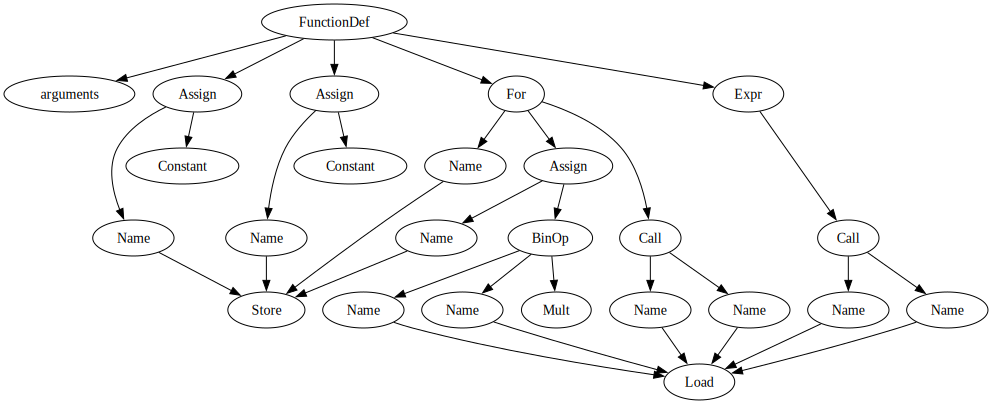

In [30]:
dot_dia

AST tree representation
An AST is a tree structure, nodes like if, test, body, assign
Each node is one concept from the program 

Recursive function can walk over the tree,  one chunk of code for each node. 

1) Good - each type of node is different, making special cases are easy
1) Bad  - each type of node is different so analysis has to know about every type, making general cases hard  

This is the classic way to write an interpreter.
Simple (non optimizing) compilers often use this format.


In [35]:
os.system('ts2bril images/toy.ts | bril2txt')

@main {
  v0: float = const 8;
  value: float = id v0;
  v1: float = const 1;
  result: float = id v1;
  v3: float = const 0;
  i: float = id v3;
.for.cond.2:
  v4: float = id i;
  v5: float = id value;
  v6: bool = flt v4 v5;
  br v6 .for.body.2 .for.end.2;
.for.body.2:
  v7: float = id result;
  v8: float = id i;
  v9: float = fmul v7 v8;
  result: float = id v9;
  v10: float = id i;
  v11: float = const 1;
  v12: float = fadd v10 v11;
  i: float = id v12;
  jmp .for.cond.2;
.for.end.2:
  v13: float = id result;
  print v13;
  v14: int = const 0;
}


0

Looks like assembly but no limit on registers, no condition codes. 
fully typed, no complex addressing modes.


syntax-  

Declare functions, labels, instructions 

instruction:  
1) variable type = opcode arguments 
2) opcode list of arguments 

## what is good and what is about this reorientation?

What is the abstract syntax form for this?



## extract info from this repreentation. 


###  control flow graph (CFG) (version 1)

Representation is a directed graph. Nodes are instructions, edges indicate ***possible*** flow of control, one entry and one exit node.

Here is a simple program:





```
    @main {
        v: int = const 5;
        print v;
    }
```

```{mermaid}
%%| fig-width: 6.5
flowchart LR
  A[const] --> B[print]
```



a second example 

```
    @main {
        v: int = const 4;
        jmp  .somewhere;
        v: int = const 2;
        .somewhere;
        print v;
    }
```

What does the control flow graph look like?


```{mermaid}
%%| fig-width: 6.5
flowchart LR
  A[const 4] --> B[jmp]
  B --> C[print]
  D[const 2] --> C
```

notice label does not produce a node

Easy to see a dead instruction.   



Third example:

```
    @main {
        v: int = const 4;
        b: bool = const false;
        br b .there .here;
    .here:
        v: int = const 2;
    .there;
        print v;
    }
```



```{mermaid}
%%| fig-width: 6.5
flowchart LR
  A[v: int const 4] --> B[b: bool const false]
  B --> C[br b .there, .false]
  C --> D[v: const 2]
  C --> E[print v]
  D --> E
```


which is the true and which is the false, could mark the edges or use a convention

Which is the entry, which is the exit?



There is a long chain of instructions entered at the top, exit at the bottom, no branches inside. 

Basic blocks (cfg form 2)
1) nodes can be a sequence of instructions. 
1) jumps and branches can only be at the end of a sequence
1) only label has to be at the start 
1) every instruction in the sequence executes the same number of times


```{mermaid}
%%| fig-width: 6.5
flowchart LR
  A[v: int const 4\nb : bool\n br ] 
  A --> D[v: const 2]
  A --> E[print v]
  D --> E
```

As we construct basic blocks, we can add instructions up till something that ends the block (***terminator***)


Option: do all blocks end in a terminator or not?

given a block b, the ***predecessors*** of b are the blocks b_in where there is an edge bin->b.
And the ***successors*** of B are the b_out where b->b_out is an edge 



## What is an algorithm that forms a cfg 
1) just find all the basic blocks 
1) add the control flow edges 

psuedo code

1) in: instructions - list of instructions
1) out blocks - list of lists of instructions 
```
current_block = []
for i in instructions:
    if i is not a label:
       block.append(i)
    if i is a label or terminator:
        blocks.append(current_block)
        current_block = []
``` 
step 2 
  we need a map from labels to basic blocks 


1) in: instructions - list of instructions
2) out blocks - list of lists of instructions 
```
current_block = []
for i in instructions:
    if i is not a label:
       block.append(i)
    if i is a label or terminator:
        blocks.append(current_block)
        current_block = []
    

for block in blocks:
   last = block[-1]
   if last is a jmp (one successor)
      add edge from block to last.dest 
   else if last is a br (two successors)
      add two edges from block to last.true, last.false 
   else  fall through 
      add edge to next block (if it exists)
```

In [45]:
with open("images/add.json", 'r') as f:
  bril_program = f.read()
  print(bril_program)


{
  "functions": [
    {
      "name": "main",
      "instrs": [
        { "op": "const", "type": "int", "dest": "v0", "value": 1 },
        { "op": "const", "type": "int", "dest": "v1", "value": 2 },
        { "op": "add", "type": "int", "dest": "v2",
          "args": ["v0", "v1"] },
        { "op": "print", "args": ["v2"] }
      ],
      "args": []
    }
  ]
}

